In [1]:
import math
import numpy as np
import math
from datasets import load_dataset

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import re
import json
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random

import ast

/Users/alessandrococcia/Desktop/MNLP HW 1/Cultural_classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
threshold = 4000

silverdataset = pd.read_csv('datasets/silver.csv')
golddataset = silverdataset.iloc[threshold:]
silverdataset = silverdataset.iloc[:threshold]

text_silver = pd.read_csv('datasets/wikipedia_text_stats_grouped_silver_links.csv')
text_gold = text_silver.iloc[threshold:]
text_silver = text_silver.iloc[:threshold]

ref_silver = pd.read_csv('datasets/wikipedia_references_stats_grouped_silver_links.csv')
ref_gold = ref_silver.iloc[threshold:]
ref_silver = ref_silver.iloc[:threshold]

In [3]:
def heuristic_from_text(column):
    nations = set(pd.read_csv('datasets/national_adjectives.csv')["Country"])
    national_adjectives = set(pd.read_csv('datasets/national_adjectives.csv')["Adjective"])

    column['new_description'] = column.apply(lambda elem: None if type(elem.iloc[0]) is float else set(elem.iloc[0].split()), axis=1)

    column['length_description_intersection'] = column['new_description'].apply(lambda elem: None if elem is None else len(elem.intersection(national_adjectives)))
    
    column['nations'] = column['new_description'].apply(lambda elem: None if elem is None else len(elem.intersection(nations)))

    return column['length_description_intersection'], column['nations']

In [4]:
# text_silver e text_gold preprocessing
silver_text_dataset = pd.DataFrame(text_silver)
#silver_text_dataset = silver_text_dataset.drop(columns=["engtext"])
gold_text_dataset = pd.DataFrame(text_gold)
#gold_text_dataset = gold_text_dataset.drop(columns=["engtext"])

array_augmentation = 1
assert(array_augmentation == 1)

#Compute size of distribution array which equals to number of wikipedia links per item. (There is one per language)
compute_len = lambda x: len(array_augmentation*ast.literal_eval(x)) if type(ast.literal_eval(x)) is not float else None
silver_text_dataset["len"] = silver_text_dataset["distribution"].apply(compute_len)
gold_text_dataset["len"] = gold_text_dataset["distribution"].apply(compute_len)

#Compute sum over the distribution array
compute_sum = lambda x: sum(array_augmentation*ast.literal_eval(x)) if type(ast.literal_eval(x)) is not float else None
silver_text_dataset["sum_over_texts"] = silver_text_dataset["distribution"].apply(compute_sum)
gold_text_dataset["sum_over_texts"] = gold_text_dataset["distribution"].apply(compute_sum)

silver_text_dataset = silver_text_dataset.drop(columns="distribution")
gold_text_dataset = gold_text_dataset.drop(columns="distribution")

n_quantili = 5

# avg, std, len are categorized based on quantili
avg_bins_edges = pd.qcut(silver_text_dataset['avg'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
std_bins_edges = pd.qcut(silver_text_dataset['std'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
len_bins_edges = pd.qcut(silver_text_dataset['len'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
sum_bins_edges = pd.qcut(silver_text_dataset['sum_over_texts'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali

silver_text_dataset['avg_bins'] = pd.cut(silver_text_dataset['avg'], bins=avg_bins_edges, include_lowest=True)
silver_text_dataset['std_bins'] = pd.cut(silver_text_dataset['std'], bins=std_bins_edges, include_lowest=True)
silver_text_dataset['len_bins'] = pd.cut(silver_text_dataset['len'], bins=len_bins_edges, include_lowest=True)
silver_text_dataset['texts_sum'] = pd.cut(silver_text_dataset['sum_over_texts'], bins=sum_bins_edges, include_lowest=True)
silver_text_dataset.dropna(subset=["len_bins"], inplace=True)
silver_text_dataset.dropna(subset=["texts_sum"], inplace=True)

gold_text_dataset['avg_bins'] = pd.cut(gold_text_dataset['avg'], bins=avg_bins_edges, include_lowest=True)
gold_text_dataset['std_bins'] = pd.cut(gold_text_dataset['std'], bins=std_bins_edges, include_lowest=True)
gold_text_dataset['len_bins'] = pd.cut(gold_text_dataset['len'], bins=len_bins_edges, include_lowest=True)
gold_text_dataset['texts_sum'] = pd.cut(gold_text_dataset['sum_over_texts'], bins=sum_bins_edges, include_lowest=True)
gold_text_dataset.dropna(subset=["len_bins"], inplace=True)
gold_text_dataset.dropna(subset=["texts_sum"], inplace=True)

#avg, std, len are dropped
silver_text_dataset = silver_text_dataset.drop(columns=["avg", "std", "len", "sum_over_texts"])
gold_text_dataset = gold_text_dataset.drop(columns=["avg", "std", "len", "sum_over_texts"])

print(silver_text_dataset.columns)

Index(['entity', 'engtext', 'avg_bins', 'std_bins', 'len_bins', 'texts_sum'], dtype='object')


In [5]:
#Now we want to combine [silverdataset, silver_text_dataset] and [goldataset, gold_text_dataset] with respect to the key <entity>
silver_merged = pd.merge(silverdataset, silver_text_dataset, left_on='item', right_on='entity')
gold_merged = pd.merge(golddataset, gold_text_dataset, left_on='item', right_on='entity')

print(len(silverdataset))
print(len(silver_text_dataset))
print(len(silver_merged))

print(len(golddataset))
print(len(gold_text_dataset))
print(len(gold_merged))

silver_merged = silver_merged.drop(columns="entity")
gold_merged = gold_merged.drop(columns="entity") 

print(silver_merged.columns)

4000
4000
2552
2251
2250
803
Index(['item', 'name', 'description', 'type', 'category', 'subcategory',
       'label', 'engtext', 'avg_bins', 'std_bins', 'len_bins', 'texts_sum'],
      dtype='object')


In [6]:
print(len(silver_merged))
print(len(gold_merged))

2552
803


In [7]:
# text_silver e text_gold preprocessing
silver_ref_dataset = pd.DataFrame(ref_silver)
gold_ref_dataset = pd.DataFrame(ref_gold)

array_augmentation = 1
assert(array_augmentation == 1)

#Compute sum over the distribution array
compute_sum = lambda x: sum(array_augmentation*ast.literal_eval(x)) if type(ast.literal_eval(x)) is not float else None
silver_ref_dataset["sum_over_ref"] = silver_ref_dataset["ref_distribution"].apply(compute_sum)
gold_ref_dataset["sum_over_ref"] = gold_ref_dataset["ref_distribution"].apply(compute_sum)

silver_ref_dataset = silver_ref_dataset.drop(columns="ref_distribution")
gold_ref_dataset = gold_ref_dataset.drop(columns="ref_distribution")

n_quantili = 5

# avg, std, len are categorized based on quantili
avg_bins_edges = pd.qcut(silver_ref_dataset['avg_ref'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
std_bins_edges = pd.qcut(silver_ref_dataset['std_ref'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
sum_bins_edges = pd.qcut(silver_ref_dataset['sum_over_ref'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali

silver_ref_dataset['avg_ref_bins'] = pd.cut(silver_ref_dataset['avg_ref'], bins=avg_bins_edges, include_lowest=True)
silver_ref_dataset['std_ref_bins'] = pd.cut(silver_ref_dataset['std_ref'], bins=std_bins_edges, include_lowest=True)
silver_ref_dataset['ref_sum'] = pd.cut(silver_ref_dataset['sum_over_ref'], bins=sum_bins_edges, include_lowest=True)
silver_ref_dataset.dropna(subset=["ref_sum"], inplace=True)

gold_ref_dataset['avg_ref_bins'] = pd.cut(gold_ref_dataset['avg_ref'], bins=avg_bins_edges, include_lowest=True)
gold_ref_dataset['std_ref_bins'] = pd.cut(gold_ref_dataset['std_ref'], bins=std_bins_edges, include_lowest=True)
gold_ref_dataset['ref_sum'] = pd.cut(gold_ref_dataset['sum_over_ref'], bins=sum_bins_edges, include_lowest=True)
gold_ref_dataset.dropna(subset=["ref_sum"], inplace=True)

#avg, std, len are dropped
silver_ref_dataset = silver_ref_dataset.drop(columns=["avg_ref", "std_ref", "sum_over_ref"])
gold_ref_dataset = gold_ref_dataset.drop(columns=["avg_ref", "std_ref", "sum_over_ref"])

print(silver_ref_dataset.columns)

Index(['entity', 'avg_ref_bins', 'std_ref_bins', 'ref_sum'], dtype='object')


In [8]:
#Now we want to combine [silverdataset, silver_ref_dataset] and [goldataset, gold_ref_dataset] with respect to the key <entity>
silver_merged = pd.merge(silver_merged, silver_ref_dataset, left_on='item', right_on='entity')
gold_merged = pd.merge(gold_merged, gold_ref_dataset, left_on='item', right_on='entity')

silver_merged = silver_merged.drop(columns="entity")
gold_merged = gold_merged.drop(columns="entity") 


In [9]:
training_data = silver_merged
evaluation_data = gold_merged

print(len(training_data))
print(len(evaluation_data))

2533
791


In [10]:
# Rimuovo colonne non utili dal training set e dall'evaluation test
dataset = training_data.drop(columns=["item", "name", "description", "engtext"])
evaluation_dataset = evaluation_data.drop(columns=["item", "name", "description", "engtext"])

In [11]:
#PREPROCESSING SU DESCRIPTION
# Heuristic su 'description'
train_desc = pd.DataFrame(training_data["description"])
dataset['h_adj_descr'], dataset['h_nat_descr'] = heuristic_from_text(train_desc)

# Stesso preprocessing per l'evaluation set
eval_desc = pd.DataFrame(evaluation_data["description"])
evaluation_dataset['h_adj_descr'], evaluation_dataset['h_nat_descr'] = heuristic_from_text(eval_desc)

In [12]:
#PREPROCESSING SU ENGTEXT
#Heuristic su engtext
train_engtext = pd.DataFrame(training_data["engtext"])
dataset['h_adj_engtext'], dataset['h_nat_engtext'] = heuristic_from_text(train_engtext)
dataset.dropna(subset=["h_adj_engtext", "h_nat_engtext"], inplace=True)

# Stesso preprocessing per l'evaluation set
eval_engtext = pd.DataFrame(evaluation_data["engtext"])
evaluation_dataset['h_adj_engtext'], evaluation_dataset['h_nat_engtext'] = heuristic_from_text(eval_engtext)
evaluation_dataset.dropna(subset=["h_adj_engtext", "h_nat_engtext"], inplace=True)


In [13]:
#Now informations on engtext are divided by quantili
n_quantili_engtext = 2
adj_engtext_bins_edges = pd.qcut(dataset['h_adj_engtext'], q=n_quantili_engtext, retbins=True)[1]
nat_engtext_bins_edges = pd.qcut(dataset['h_nat_engtext'], q=n_quantili_engtext, retbins=True)[1]

dataset['adj_engtext_bins'] = pd.cut(dataset['h_adj_engtext'], bins=adj_engtext_bins_edges, include_lowest=True)
dataset['nat_engtext_bins'] = pd.cut(dataset['h_nat_engtext'], bins=nat_engtext_bins_edges, include_lowest=True)

evaluation_dataset['adj_engtext_bins'] = pd.cut(evaluation_dataset['h_adj_engtext'], bins=adj_engtext_bins_edges, include_lowest=True)
evaluation_dataset['nat_engtext_bins'] = pd.cut(evaluation_dataset['h_nat_engtext'], bins=nat_engtext_bins_edges, include_lowest=True)

#Now drop the original columns
dataset = dataset.drop(columns=["h_adj_engtext", "h_nat_engtext"])
evaluation_dataset = evaluation_dataset.drop(columns=["h_adj_engtext", "h_nat_engtext"])

In [14]:
# Colonne categoriali da codificare
#categorical_columns = ["h_description", "nations", "type", "category", "subcategory", "label", "avg_bins", "std_bins", "len_bins", "texts_sum"]
#dataset, evaluation_dataset = train_test_split(dataset, test_size=0.7, random_state=42, shuffle=True)

categorical_columns = dataset.columns

print(categorical_columns)

# Inizializza OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(dataset[categorical_columns])

# Trasforma separatamente training e evaluation
encoded_train = encoder.transform(dataset[categorical_columns])
encoded_eval = encoder.transform(evaluation_dataset[categorical_columns])

# Crea DataFrame dalle codifiche
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns), index=dataset.index)
encoded_eval_df = pd.DataFrame(encoded_eval, columns=encoder.get_feature_names_out(categorical_columns), index=evaluation_dataset.index)
# Rimuovi le colonne originali e aggiungi quelle codificate
dataset = dataset.drop(columns=categorical_columns)
dataset = pd.concat([dataset, encoded_train_df], axis=1)

evaluation_dataset = evaluation_dataset.drop(columns=categorical_columns)
evaluation_dataset = pd.concat([evaluation_dataset, encoded_eval_df], axis=1)

# Seleziono feature e target
labels = ['label_cultural agnostic', 'label_cultural exclusive', 'label_cultural representative']
X_train = dataset.drop(columns=labels)
#Dropping worst features
#X_train = X_train.drop(columns=worst_features)
y_train = dataset[labels]

X_test = evaluation_dataset.drop(columns=labels)
#X_test = X_test.drop(columns=worst_features)
y_test = evaluation_dataset[labels]

rf_model = RandomForestClassifier(n_estimators=2000, criterion='gini', random_state=43)
rf_model.fit(X_train, y_train)

# Predizioni sul test set
y_pred = rf_model.predict(X_test)

# Accuratezza
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"Accuratezza del modello: {accuracy:.2f}")
print(f"f1 score del modello: {f1:.2f}")

Index(['type', 'category', 'subcategory', 'label', 'avg_bins', 'std_bins',
       'len_bins', 'texts_sum', 'avg_ref_bins', 'std_ref_bins', 'ref_sum',
       'h_adj_descr', 'h_nat_descr', 'adj_engtext_bins', 'nat_engtext_bins'],
      dtype='object')
Accuratezza del modello: 0.60
f1 score del modello: 0.65


In [15]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
print(len(y_test))

789
2533
2533
789


173


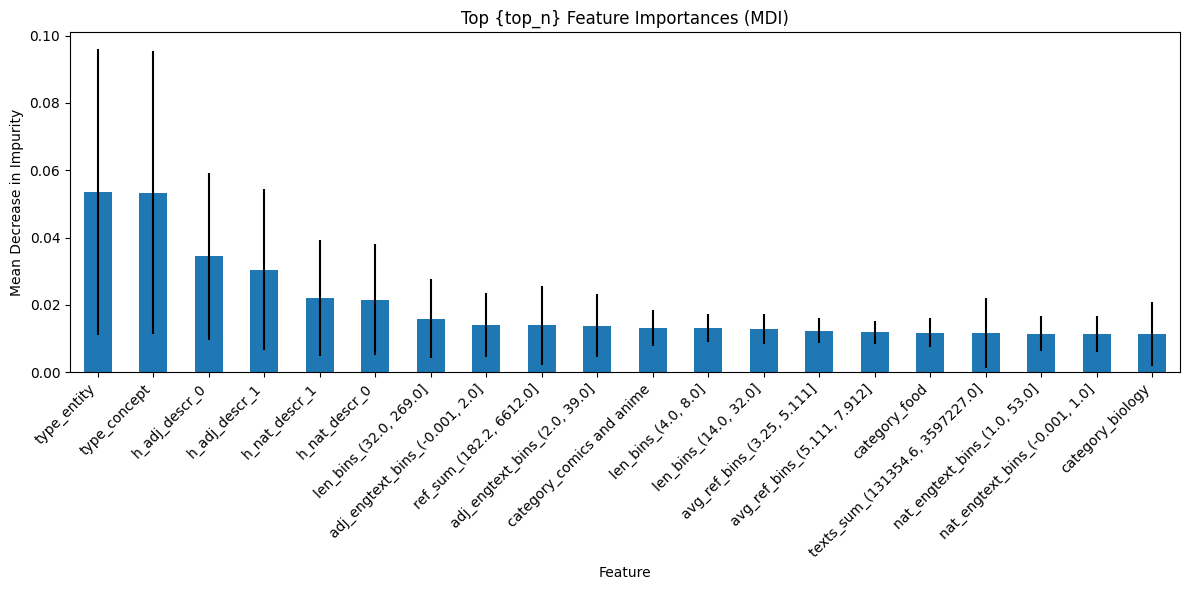

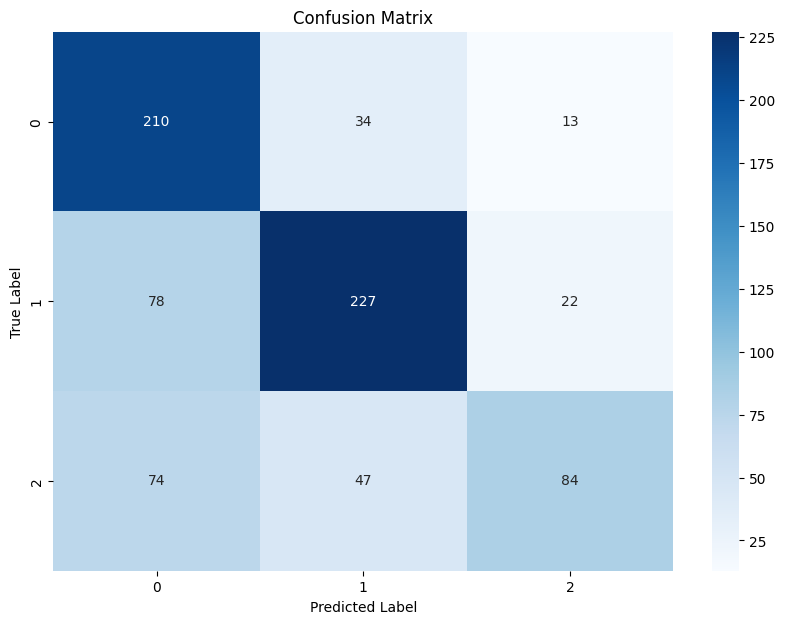

In [16]:
#ANALITICS

# Crea i nomi delle feature (se non li hai già)
feature_names = X_train.columns.tolist()
# Calcola le importanze medie e deviazione standard tra tutti gli alberi
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Serie ordinata con le feature
forest_importances = pd.Series(importances, index=feature_names)

# Ordina e prendi le top 20
top_n = 20
print(len(forest_importances))
top_features = forest_importances.sort_values(ascending=False).head(top_n)
worst_features = forest_importances.sort_values(ascending=True).head(10).index.tolist()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
top_features.plot.bar(yerr=std[[feature_names.index(f) for f in top_features.index]], ax=ax)
ax.set_title("Top {top_n} Feature Importances (MDI)")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()